In [1]:
!pip install --upgrade --force-reinstall git+https://github.com/FelipeSchreiber/BregmanClustering.git

  Cloning https://github.com/FelipeSchreiber/BregmanClustering.git to /tmp/pip-req-build-xkcfj124
  Running command git clone --filter=blob:none --quiet https://github.com/FelipeSchreiber/BregmanClustering.git /tmp/pip-req-build-xkcfj124
  Resolved https://github.com/FelipeSchreiber/BregmanClustering.git to commit b4b8ec18ad2400ca8d748cd76349c479b08535a3
  Preparing metadata (setup.py) ... done
  Created wheel for bregClust: filename=bregClust-0.1-py3-none-any.whl size=10247 sha256=d13a56e5577f51ae4905c1b7718357bc49fd93e58967547d8696d1ed5a918f3b
  Stored in directory: /tmp/pip-ephem-wheel-cache-gw8qiiii/wheels/6f/8f/ab/2faa84d8b9fad58989d72cda12225f6191888313b2d42f6ad5
Successfully built bregClust
  Attempting uninstall: bregClust
    Found existing installation: bregClust 0.1
    Uninstalling bregClust-0.1:
      Successfully uninstalled bregClust-0.1


In [2]:
%matplotlib inline
from BregmanClustering.WSBM import *
from copy import deepcopy
from sklearn.metrics import adjusted_rand_score, calinski_harabasz_score, normalized_mutual_info_score, accuracy_score
from signet.cluster import Cluster
from sklearn.manifold import spectral_embedding,SpectralEmbedding
import scipy.sparse as ss
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics.pairwise import pairwise_kernels
import sys
sys.path.insert(1, '/home/felipe/Documentos/CSBM-main/Python')
import functions as CSBM
import dataframe_image as dfi
import os
import warnings
from BregmanClustering import models
from BregmanClustering.models import SoftBregmanNodeAttributeGraphClustering as VEMbreg
from BregmanClustering.models import SpectralBregmanNodeAttributeGraphClustering as Sbreg
import subprocess
warnings.filterwarnings("ignore")

In [3]:
method = 'hard'
initialization="akaike"
path = "/home/felipe/Documentos/BregmanBenchmark/data/Dreveton_benchmark/"

In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Feb 17 17:08:00 2023

@author: maximilien
"""
from tqdm import tqdm

SIZE_TITLE = 24
SIZE_LABELS = 24
SIZE_TICKS = 18
SIZE_LEGEND = 18

def unitRootCoordinates( d = 2, r=1 ):
    coordinates = []
    for k in range( d ):
        coordinates.append( [ r*np.cos(2*k*np.pi / d ), r*np.sin( 2*k*np.pi / d ) ])
    return coordinates

def generateData( sizes, p, mu ):
    n = sum( sizes )
    n_clusters = len( sizes )
    d = len( mu[0] )
    
    labels_true = [ ]
    for k in range( n_clusters ):
        labels_true += [ k for i in range( sizes[ k ] ) ]
    labels_true = np.asarray( labels_true, dtype = int )

    G = nx.stochastic_block_model( sizes, p )
    X = nx.adjacency_matrix( G ).todense()
    
    Y = np.zeros( ( n,d ) )
    for i in range( n ):
        Y[i,:] = np.random.normal( loc = mu[ labels_true[i] ] )
    return np.asarray(X), Y, labels_true


def plotting( x, curves, labels, xticks,
             curves_std = None,
             legendTitle = '', figTitle = '',
             xlabel = 'a', ylabel = 'ARI',
             saveFig = False, fileName = 'fig.eps'):
    
    if len( curves ) != len( labels ):
        raise TypeError( 'The number of labels is different from the number of curves' )
    
    if curves_std == None:
        for i in range( len( labels) ):
            plt.plot( x, curves[i], label = labels[i])
    else:
        for i in range( len( labels) ):
            plt.errorbar( x, curves[ i ], yerr = curves_std[ i ], linestyle = '-.', label = labels[ i ] )

    
    legend = plt.legend( title = legendTitle, loc=4,  fancybox=True, fontsize= SIZE_LEGEND )
    plt.setp( legend.get_title(),fontsize= SIZE_LEGEND )
    plt.xlabel( xlabel, fontsize = SIZE_LABELS )
    plt.ylabel( ylabel, fontsize = SIZE_LABELS )
    plt.xticks( xticks, fontsize = SIZE_TICKS )
    plt.yticks( fontsize = SIZE_TICKS )
    plt.title( figTitle, fontsize = SIZE_TITLE )
    if saveFig:
        plt.savefig( fileName, format = 'eps', bbox_inches = 'tight' )

#Somehow some errors message sometimes arises such as 
#RuntimeWarning: divide by zero encountered in log
#But this shouldn be a problem

In [5]:
c = 3
n = 100
N = c*n
delta = 10
d = 2
dim = c*d
P = np.array([[0.8, 0.2, 0.3],[0.2, 0.7, 0.4],[0.3, 0.4, 0.6]])
true_labels = [0]*n + [1]*n + [2]*n

In [6]:
X,Y = BregmanBenchmark(P,[n]*c,1,10,dims=2,weight_variance=0.01,att_variance=0.1,\
                       weight_distribution="logistic",attributes_distribution="logistic").generate_benchmark_WSBM()
A = (X != 0).astype(int)

In [7]:
X

array([[0.  , 0.94, 1.03, ..., 0.  , 4.67, 0.  ],
       [0.94, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [1.03, 0.  , 0.  , ..., 4.64, 0.  , 4.7 ],
       ...,
       [0.  , 0.  , 4.64, ..., 0.  , 0.  , 9.93],
       [4.67, 0.  , 0.  , ..., 0.  , 0.  , 9.89],
       [0.  , 0.  , 4.7 , ..., 9.93, 9.89, 0.  ]])

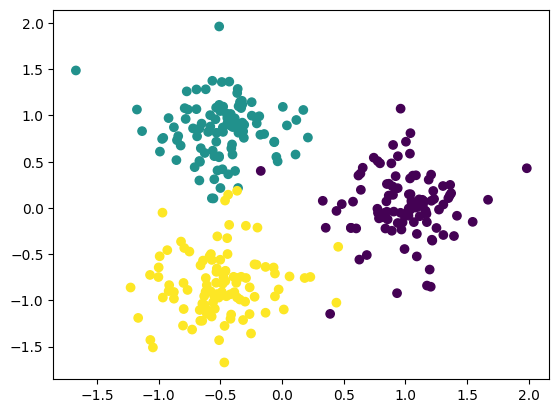

In [8]:
plt.scatter(Y[:,0],Y[:,1],c=true_labels)

In [9]:
def get_spectral_decomposition(A,k):
    if (A<0).any():
        A = pairwise_kernels(A,metric='rbf')
    U = SpectralEmbedding(n_components=k,affinity="precomputed").fit_transform(A)
    return U
def spectral(A,k):
    U = get_spectral_decomposition(A,k)
    return GaussianMixture(n_components=k).fit_predict(U.real)
pred_labels = spectral(X.copy(),c)
print(adjusted_rand_score(true_labels, pred_labels),normalized_mutual_info_score(true_labels, pred_labels))

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f26c547d670>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

1.0 1.0


In [10]:
pred_labels = GaussianMixture(n_components=c).fit_predict(Y.copy())
print(adjusted_rand_score(true_labels, pred_labels),normalized_mutual_info_score(true_labels, pred_labels))

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f26c549f820>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

0.9405654945295762 0.9080518044574142


In [11]:
model = Sbreg(n_clusters=c,thresholding=True,normalize_=True,scaler=StandardScaler())
model.fit(A, Y)
z_pred_both = model.predict(A,Y)
z_pred_att = models.frommembershipMatriceToVector( model.memberships_from_attributes )
z_pred_graph = models.frommembershipMatriceToVector( model.memberships_from_graph )
print(adjusted_rand_score(true_labels, z_pred_both),normalized_mutual_info_score(true_labels, z_pred_both))

[[0.6  0.4  0.3 ]
 [0.4  0.69 0.2 ]
 [0.3  0.2  0.8 ]]
Initialisation chosen from the graph
0


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f26c549f820>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

1


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f26c4ec0ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

1.0 1.0


In [16]:
n_average = 1
n = 300
n_clusters = 2
d = 1
sizes = [ n // n_clusters ]*np.ones( n_clusters, dtype = int )

b = 5
pout = b * np.log( n ) / n

# a_range = [ 5,7,9,11,13,15 ]
# r_range = [ 0,1,2,3,4,5 ]
a_range = [ 5,7,9]
r_range = [ 0,1,2]


stats = {"varying":[],"a":[],"r":[],"agreed":[],"ARI_chernoff":[],"ARI_AIC":[]}

for varying in ["attributes","graph"]:
# varying = 'attributes'
# #varying = 'graph'

    aris_attributes_mean = [ ]
    aris_graph_mean = [ ]
    aris_both_mean = [ ]
    aris_attSBM_mean = [ ]
    aris_IR_sLS_mean = [ ]
    aris_IR_LS_mean = [ ]
    aris_both2_mean = [ ]

    aris_attributes_std = [ ]
    aris_graph_std = [ ]
    aris_both_std = [ ]
    aris_attSBM_std = [ ]
    aris_IR_sLS_std = [ ]
    aris_IR_LS_std = [ ]
    aris_both2_std = [ ]

    if varying == 'graph':
        loop = tqdm( range( len( a_range ) ) )
    else:
        loop = tqdm( range( len( r_range ) ) )

    for dummy in loop:
        if varying == 'graph':
            a = a_range[ dummy ]
            r = 1
        elif varying == 'attributes':
            a = 8
            r = r_range[ dummy ]
        mu = np.array([ [r], [-r] ])
        #print(mu.shape)
        #mu = unitRootCoordinates( d=2, r=r )

        pin = a * np.log( n ) / n
        p = (pin- pout) * np.eye( n_clusters ) + pout * np.ones( (n_clusters, n_clusters) )

        aris_attributes = [ ]
        aris_graph = [ ]
        aris_both = [ ]
        aris_attSBM = []
        aris_IR_sLS  = []
        aris_IR_LS = []
        aris_both2 = [ ]

        path_ = path+f"a/{a}/r/{r}/"
        if not os.path.exists(path_):
            os.makedirs(path_)

        total = 0
        for trial in range( n_average ):
            ( X, Y, z_true ) = generateData( sizes, p, mu )
            model = models.BregmanNodeAttributeGraphClustering( n_clusters = n_clusters, initializer="chernoff")
            ## For comparison purposes, the initialization is the same for IR-sLS, IR-LS and ours    
            model.initialize( X, Y )
            model.assignInitialLabels( X, Y )
            z_init = model.predicted_memberships.copy()

            with open(f'{path_}att_{trial}.npy', 'wb') as g:
                np.save(g, Y)
            with open(f'{path_}net_{trial}.npy', 'wb') as g:
                np.save(g, X)
            with open(f'{path_}z_init_{trial}.npy', 'wb') as g:
                np.save(g, CSBM.convertZ(z_init)+1)

            model.fit( X, Y )
            z_pred_both = model.predict( X, Y )
            z_pred_graph = models.frommembershipMatriceToVector( model.memberships_from_graph )
            z_pred_attributes = models.frommembershipMatriceToVector( model.memberships_from_attributes )
            IR_sLS_pred = CSBM.iter_csbm(X,Y,z_init,n_clusters)
            IR_LS_pred = CSBM.iter_csbm2(X,Y,z_init,n_clusters)

            model2 = Sbreg(n_clusters=c,thresholding=True,normalize_=False,n_iters=5,scaler=MinMaxScaler())
            model2.fit( X, Y )
            z_pred_both2 = model2.predict( X, Y )

            if model2.graph_init == model.graph_init:
                total += 1

            subprocess.call(["Rscript" ,"--vanilla","/home/felipe/Documentos/BregmanBenchmark/run_AttSBM.r",\
                            f'{path_}att_{trial}.npy',\
                            f'{path_}net_{trial}.npy',\
                            f'{path_}z_init_{trial}.npy'])

            attSBMPred = np.load("predict.npy")

            aris_attributes.append( adjusted_rand_score( z_true, z_pred_attributes ) )
            aris_graph.append( adjusted_rand_score( z_true, z_pred_graph ) )
            aris_both.append( adjusted_rand_score( z_true, z_pred_both ) )
            aris_attSBM.append( adjusted_rand_score( z_true, attSBMPred ) )
            aris_IR_sLS.append( adjusted_rand_score( z_true, IR_sLS_pred ) )
            aris_IR_LS.append( adjusted_rand_score( z_true, IR_LS_pred ) )
            aris_both2.append( adjusted_rand_score( z_true, z_pred_both2 ))

        aris_attributes_mean.append( np.mean( aris_attributes ) )
        aris_graph_mean.append( np.mean( aris_graph ) )
        aris_both_mean.append( np.mean( aris_both ) )
        aris_attSBM_mean.append( np.mean( aris_attSBM ) )
        aris_IR_sLS_mean.append( np.mean( aris_IR_sLS ) )
        aris_IR_LS_mean.append( np.mean( aris_IR_LS ) )
        aris_both2_mean.append( np.mean( aris_both2) )
        print(aris_both2_mean[-1])
        
        aris_attributes_std.append( np.std( aris_attributes ) )
        aris_graph_std.append( np.std( aris_graph ) )
        aris_both_std.append( np.std( aris_both ) )
        aris_attSBM_std.append( np.std( aris_attSBM ) )
        aris_IR_sLS_std.append( np.std( aris_IR_sLS ) )
        aris_IR_LS_std.append( np.std( aris_IR_LS ) )
        aris_both2_std.append( np.std( aris_both2 ) )

        stats["varying"].append(varying)
        stats["a"].append(a)
        stats["r"].append(r)
        stats["agreed"].append(total/n_average)
        stats["ARI_chernoff"].append(aris_both_mean[-1])
        stats["ARI_AIC"].append(aris_both2_mean[-1])

    curves = [ aris_attributes_mean, aris_graph_mean,\
              aris_both_mean , aris_attSBM_mean, aris_IR_sLS_mean,\
              aris_IR_LS_mean, aris_both2_mean]

    curves_std = [ aris_attributes_std, aris_graph_std,\
                  aris_both_std , aris_attSBM_std, aris_IR_sLS_std,\
                  aris_IR_LS_std, aris_both2_std]

    labels = [ 'attributes', 'graph', 'both' , 'attSBM', 'IR_sLS', 'IR_LS', "both2"]
    saveFig = True
    if varying == 'graph':    
        fileName = 'N_' + str(n) + '_K_' + str(n_clusters) + '_b_' + str(b) + '_r_' + str(r) +  '_nAverage' + str(n_average) + '.eps'
        plotting( a_range, curves, labels, curves_std = curves_std, xticks = a_range, xlabel = 'a', saveFig = saveFig, fileName = fileName )
        plt.close()
    elif varying == 'attributes':
        fileName = 'N_' + str(n) + '_K_' + str(n_clusters) + '_a_' + str(a) + '_b_' + str(b) +  '_nAverage_' + str(n_average) + '.eps'
        plotting( r_range, curves, labels, curves_std = curves_std, xticks = r_range, xlabel = 'r', saveFig = saveFig, fileName = fileName )
        plt.close()

  0%|                                                                                                                   | 0/3 [00:00<?, ?it/s]

Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
[[0.15 0.1  0.1 ]
 [0.1  0.18 0.09]
 [0.1  0.09 0.18]]
Initialisation chosen from the graph
0


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f26d818b940>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

1


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f26d818bb80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

2


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f26d818b940>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

3


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f26e2881670>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

4


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f26d818bb80>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

5


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f26e2881670>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

6


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f26c4ec0ca0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

[1] TRUE



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

 33%|███████████████████████████████████▎                                                                      | 1/3 [02:18<04:37, 138.89s/it]

0.005539331685940683
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
[[0.16 0.1  0.1 ]
 [0.1  0.17 0.11]
 [0.1  0.11 0.17]]
Initialisation chosen from the graph
0


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f26b85133a0>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

1


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f26c4ec0280>
Traceback (most recent call last):
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/felipe/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

2


 33%|███████████████████████████████████▎                                                                      | 1/3 [03:21<06:43, 201.51s/it]


ValueError: Input X contains NaN.
GaussianMixture does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
import pandas as pd
df = pd.DataFrame.from_dict(stats)

In [ ]:
df